# Data preprocessing
- Imported Data from CSV
- Removed irrelavant data(NAN)
- Plotted ax and ay wrt time

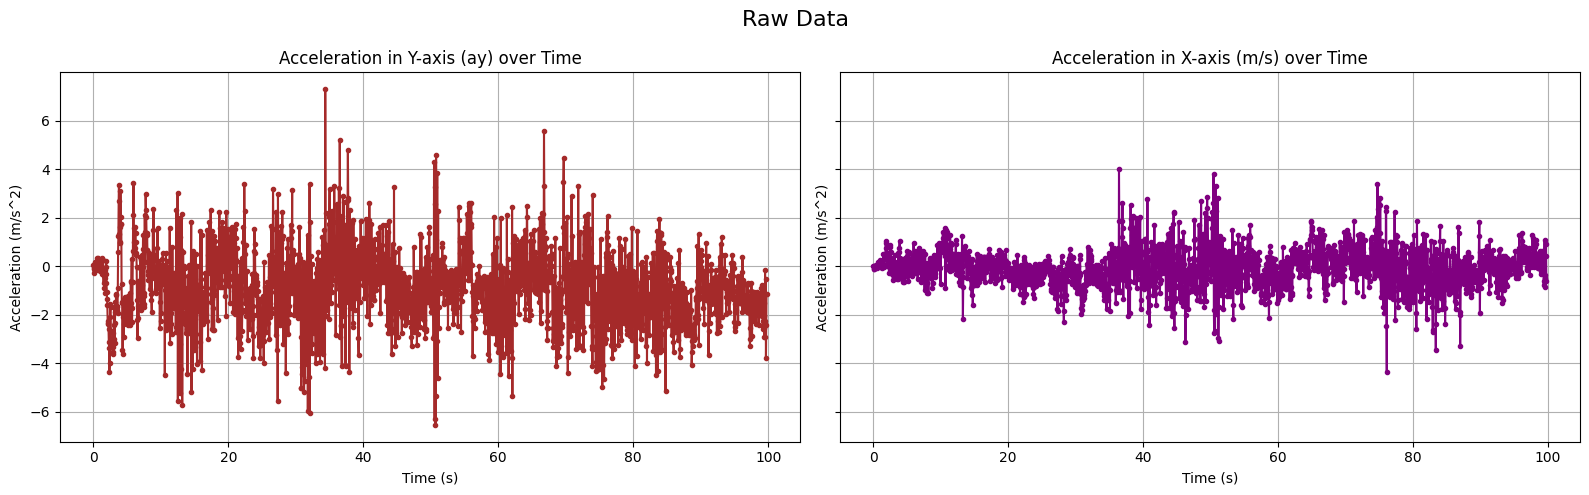

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

df = pd.read_csv('data6.csv')
# print(df.to_string())

df = df.dropna()
# print(df.to_string())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle('Raw Data', fontsize=16)
ax1.plot(df['time'], df['ay'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (m/s) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)

plt.tight_layout() 
plt.show()


# DC Bias Removal(Sensor Calibration)

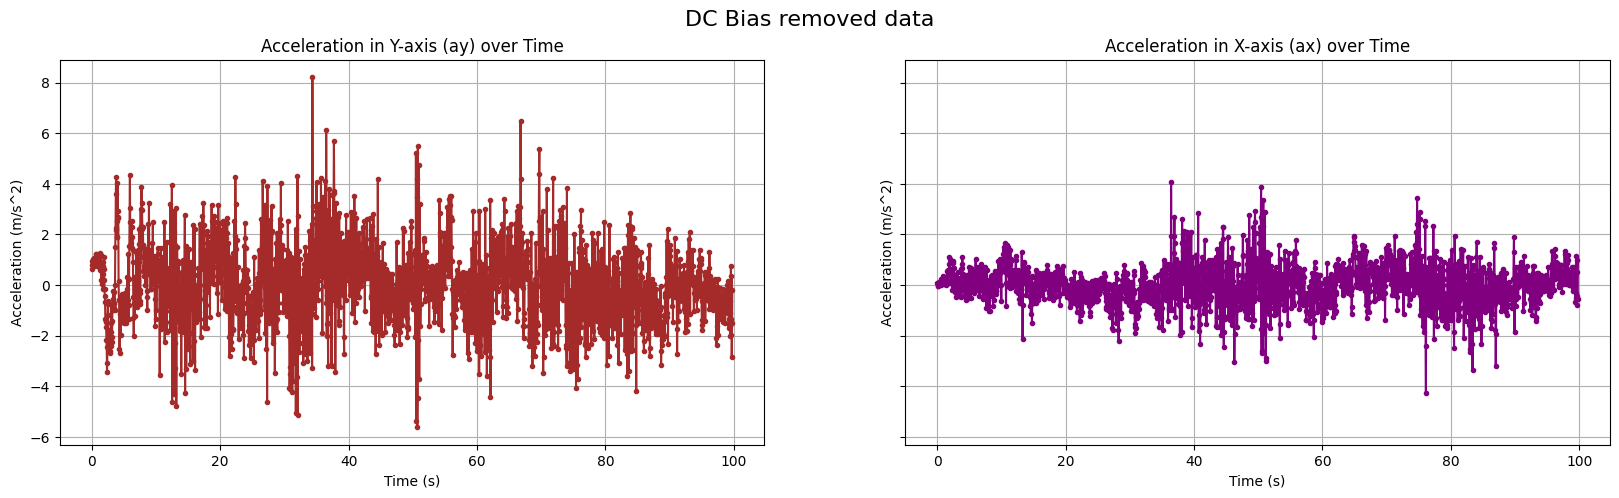

In [49]:
df['ay_bias'] = df['ay'].copy()  # Make a copy of ay
df['ax_bias'] = df['ax'].copy()  # Make a copy of ax

ay_mean = df['ay_bias'].mean()
ax_mean = df['ax_bias'].mean()

for i in range (0,len(df)):
    df.loc[i, 'ay_bias'] = df.loc[i, 'ay_bias'] - ay_mean
    df.loc[i, 'ax_bias'] = df.loc[i, 'ax_bias'] - ax_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('DC Bias removed data', fontsize=16)
ax1.plot(df['time'], df['ay_bias'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax_bias'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)



# Exponential Moving Average Filter

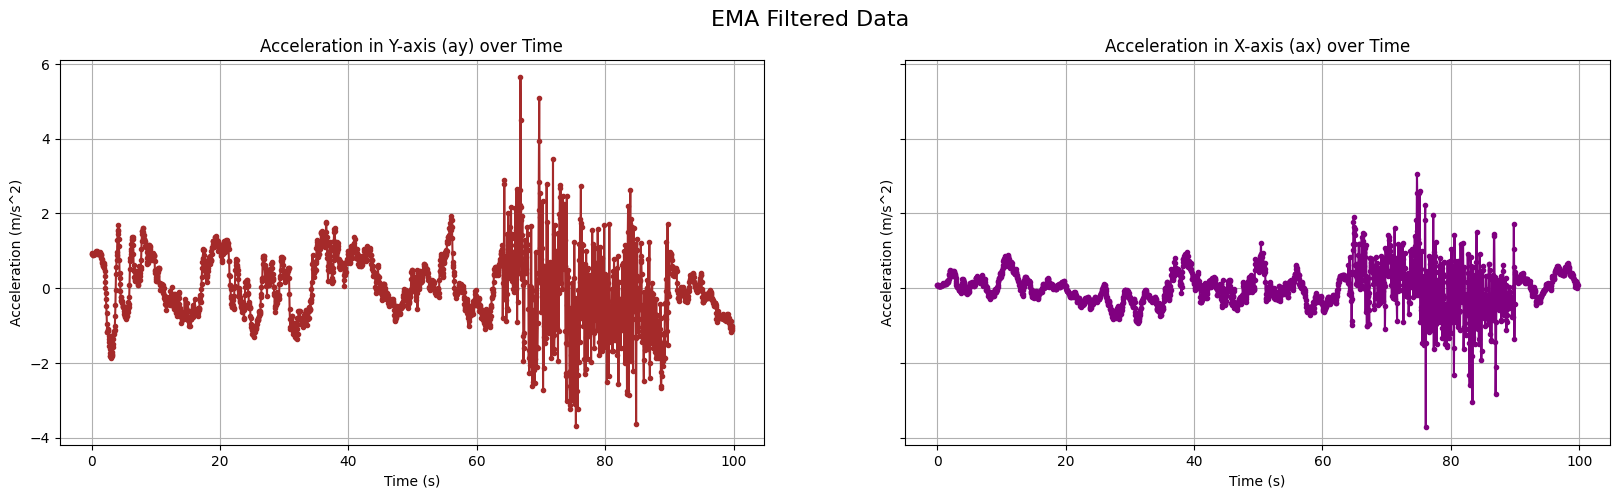

In [50]:
# Set initial values for the EMA columns based on the bias-removed acceleration values
df['ay_ema'] = df['ay_bias'].copy()
df['ax_ema'] = df['ax_bias'].copy()

# Define parameters
alpha_high = 0.1  # Smoothing factor for normal conditions (more smoothing)
alpha_low = 0.8   # Smoothing factor for sharp turns (less smoothing)

# Loop through the DataFrame to apply the adaptive EMA filter
for i in range(1, len(df)):
    # Set alpha based on the time condition
    if df.loc[i, 'time'] > 64 and df.loc[i, 'time'] < 90:
        alpha = alpha_low
    else:
        alpha = alpha_high

    # Apply adaptive EMA filter
    df.loc[i, 'ay_ema'] = df.loc[i - 1, 'ay_ema'] * (1 - alpha) + df.loc[i, 'ay_bias'] * alpha
    df.loc[i, 'ax_ema'] = df.loc[i - 1, 'ax_ema'] * (1 - alpha) + df.loc[i, 'ax_bias'] * alpha

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('EMA Filtered Data', fontsize=16)
ax1.plot(df['time'], df['ay_ema'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax_ema'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)

# Velocity Estimation

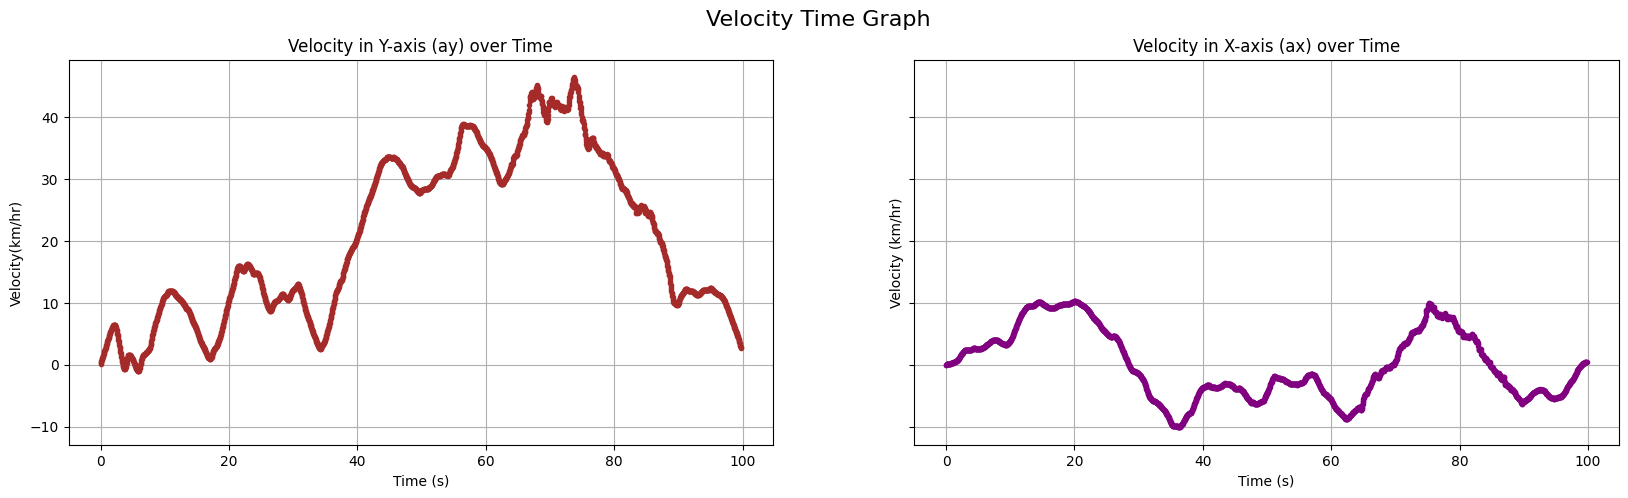

In [51]:
df['vy'] = df['ay_ema'].copy()  # Copy ay for Velocity estimation
df['vx'] = df['ax_ema'].copy()  # Copy ax for Velocity estimation

for i in range(1,len(df)):
    df.loc[i, 'vy'] = (df.loc[i - 1, 'vy'] + df.loc[i, 'ay_ema'] ) 
    df.loc[i, 'vx'] = (df.loc[i - 1, 'vx'] + df.loc[i, 'ax_ema'] ) 

df['vy'] = df['vy'] /23  # Divide by 23 since 23 samples/s
df['vx'] = df['vx'] /23 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Velocity Time Graph', fontsize=16)
ax1.plot(df['time'], df['vy']*18/5, marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Velocity in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Velocity(km/hr)') 
ax1.grid(True)

ax2.plot(df['time'], df['vx']*18/5, marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Velocity in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Velocity (km/hr)') 
ax2.grid(True)


# Distance Estimation

Distance travelled in X-axis: 0.3910067132978056
Distance travelled in Y-axis: 573.7996494494942
Net Distance: 573.799782672155
        time      ax       ay       az       yaw   ay_bias   ax_bias    ay_ema    ax_ema         vy        vx          sy         sx
0      0.000  0.0166  0.03685   9.8658    0.0000  0.948314  0.086511  0.948314  0.086511   0.041231  0.003761    0.001793   0.000164
1      0.043  0.0237 -0.27918   9.8143  340.3018  0.632284  0.093611  0.916711  0.087221   0.081088  0.007554    0.005318   0.000492
2      0.086  0.0106 -0.11066   9.9268  322.0084  0.800804  0.080511  0.905120  0.086550   0.120441  0.011317    0.010555   0.000984
3      0.129 -0.1103 -0.08030   9.8741  306.9310  0.831164 -0.040389  0.897724  0.073856   0.159473  0.014528    0.017488   0.001616
4      0.172 -0.1115  0.00924   9.9292  295.6838  0.920704 -0.041589  0.900022  0.062312   0.198604  0.017237    0.026123   0.002365
5      0.215 -0.0601  0.12903   9.6766  287.8154  1.040494  0.009811  0.91

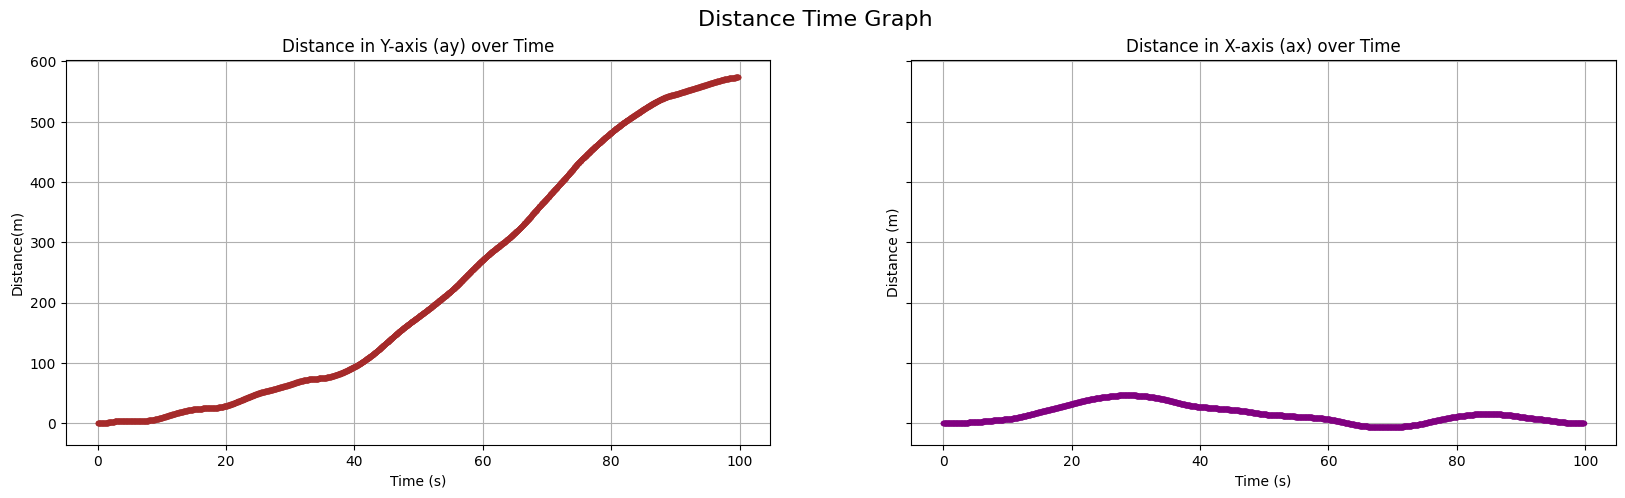

In [52]:
df['sy'] = df['vy'].copy()  # Copy ay for Velocity estimation
df['sx'] = df['vx'].copy()  # Copy ax for Velocity estimation

for i in range(1,len(df)):
    df.loc[i, 'sy'] = (df.loc[i - 1, 'sy'] + df.loc[i, 'vy'] )
    df.loc[i, 'sx'] = (df.loc[i - 1, 'sx'] + df.loc[i, 'vx']) 

df['sy'] = df['sy'] /23  # Divide by 23 since 23 samples/s
df['sx'] = df['sx'] /23 

dx = df['sx'].iloc[-1]
dy = df['sy'].iloc[-1]
distance = math.sqrt(dx**2 + dy**2)
print('Distance travelled in X-axis:',dx)
print('Distance travelled in Y-axis:',dy)
print('Net Distance:',distance)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Distance Time Graph', fontsize=16)
ax1.plot(df['time'], df['sy'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Distance in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Distance(m)') 
ax1.grid(True)

ax2.plot(df['time'], df['sx'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Distance in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Distance (m)') 
ax2.grid(True)
print(df.to_string())

# Converting Distances to Global frame of reference(NWU)

In [53]:
df['Dn'] = df['sx'] * np.cos(np.radians(df['yaw'])) - df['sy'] * np.sin(np.radians(df['yaw']))
df['Dw'] = -df['sx'] * np.sin(np.radians(df['yaw'])) - df['sy'] * np.cos(np.radians(df['yaw']))

df['distance'] = np.sqrt(df['Dn']**2 + df['Dw']**2)
print(df.to_string())


        time      ax       ay       az       yaw   ay_bias   ax_bias    ay_ema    ax_ema         vy        vx          sy         sx          Dn          Dw    distance
0      0.000  0.0166  0.03685   9.8658    0.0000  0.948314  0.086511  0.948314  0.086511   0.041231  0.003761    0.001793   0.000164    0.000164   -0.001793    0.001800
1      0.043  0.0237 -0.27918   9.8143  340.3018  0.632284  0.093611  0.916711  0.087221   0.081088  0.007554    0.005318   0.000492    0.002256   -0.004841    0.005341
2      0.086  0.0106 -0.11066   9.9268  322.0084  0.800804  0.080511  0.905120  0.086550   0.120441  0.011317    0.010555   0.000984    0.007272   -0.007713    0.010601
3      0.129 -0.1103 -0.08030   9.8741  306.9310  0.831164 -0.040389  0.897724  0.073856   0.159473  0.014528    0.017488   0.001616    0.014950   -0.009216    0.017563
4      0.172 -0.1115  0.00924   9.9292  295.6838  0.920704 -0.041589  0.900022  0.062312   0.198604  0.017237    0.026123   0.002365    0.024567   -0.00919

# Latitude and Longitude Calculation

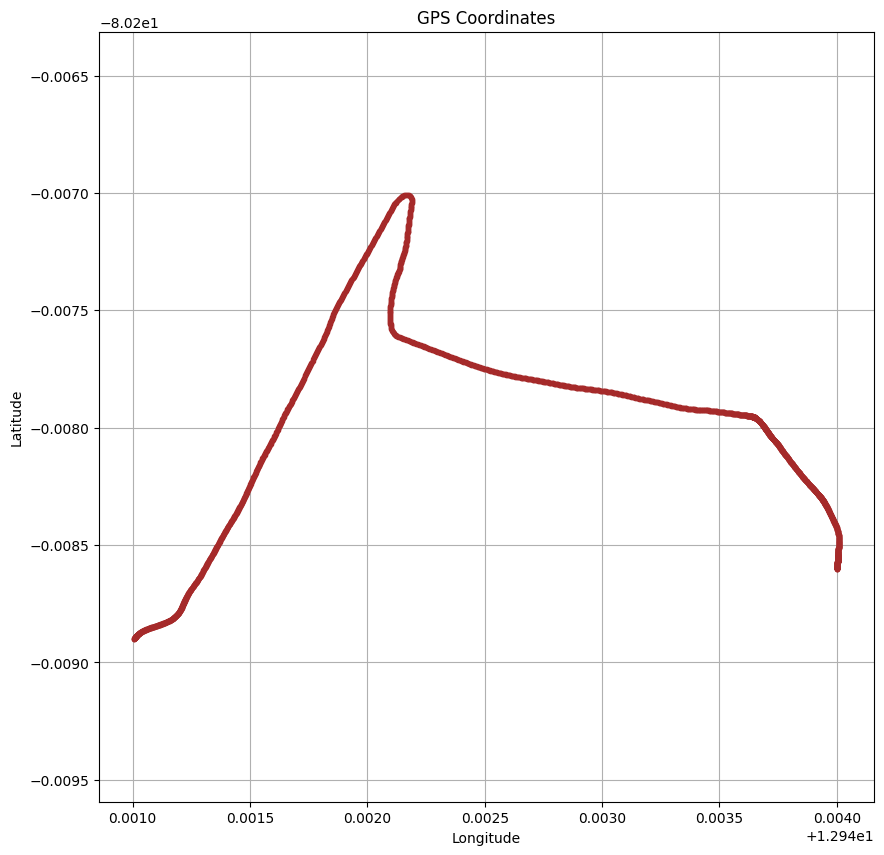

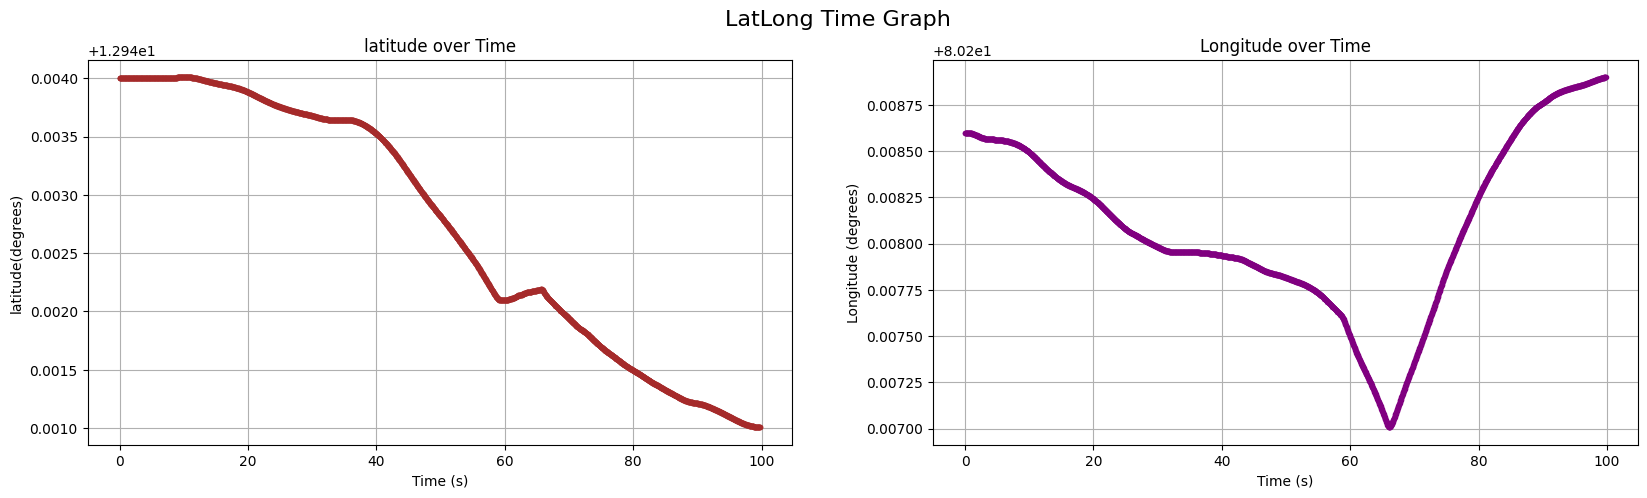

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df, initial_lat, initial_lon are already defined
#linear  lat = 12.945640, lon = 80.212978
#cirular 12.945866, lon = 80.212048
initial_lat = 12.945866
initial_lon = 80.212048

# Set initial coordinates
df.loc[0, 'lat'] = initial_lat
df.loc[0, 'lon'] = initial_lon

# Function to convert distance and heading to new coordinates
def convert_distance_to_coordinates(lat1, lon1, distance, heading):
    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    heading_rad = np.radians(heading)

    # Convert distance to radians
    delta = distance / 6371000  # Earth's radius in meters

    # Calculate final latitude and longitude
    lat2_rad = np.arcsin(np.sin(lat1_rad) * np.cos(delta) + np.cos(lat1_rad) * np.sin(delta) * np.cos(heading_rad))
    lon2_rad = lon1_rad + np.arctan2(np.sin(heading_rad) * np.sin(delta) * np.cos(lat1_rad),
                                      np.cos(delta) - np.sin(lat1_rad) * np.sin(lat2_rad))

    # Convert radians back to degrees
    lat2 = np.degrees(lat2_rad)
    lon2 = np.degrees(lon2_rad)

    return lat2, lon2

# Loop to calculate and update coordinates
for i in range(1, len(df)):
    lat, lon = convert_distance_to_coordinates(df.loc[i - 1, 'lat'], df.loc[i - 1, 'lon'], df.loc[i, 'distance']-df.loc[i-1, 'distance'], df.loc[i, 'yaw'])
    df.loc[i, 'lat'] = lat
    df.loc[i, 'lon'] = lon

# Plotting the path
plt.figure(figsize=(10, 10))  
plt.plot(df['lat'] , df['lon']*-1, marker='o', linestyle='-', color='brown', markersize=3)
plt.title('GPS Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axis('equal')  # Set equal scale for x and y axes
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('LatLong Time Graph', fontsize=16)
ax1.plot(df['time'], df['lat'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('latitude over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('latitude(degrees)') 
ax1.grid(True)

ax2.plot(df['time'], df['lon'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Longitude over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Longitude (degrees)') 
ax2.grid(True)

In [55]:

new_df = df[['time', 'ax', 'ay', 'az', 'yaw', 'distance']].copy()

# Convert the new dataframe to a CSV file
print(new_df.to_string())   
# new_df.to_csv('new_round1.csv', index=False)


        time      ax       ay       az       yaw    distance
0      0.000  0.0166  0.03685   9.8658    0.0000    0.001800
1      0.043  0.0237 -0.27918   9.8143  340.3018    0.005341
2      0.086  0.0106 -0.11066   9.9268  322.0084    0.010601
3      0.129 -0.1103 -0.08030   9.8741  306.9310    0.017563
4      0.172 -0.1115  0.00924   9.9292  295.6838    0.026230
5      0.215 -0.0601  0.12903   9.6766  287.8154    0.036628
6      0.258 -0.0038  0.05005   9.8011  282.4937    0.048766
7      0.301 -0.0098  0.17248   9.7820  278.9474    0.062675
8      0.344  0.0477 -0.15543   9.7904  276.5872    0.078323
9      0.387 -0.0158  0.10142   9.7987  275.0317    0.095727
10     0.430  0.0261 -0.08558   9.9819  274.0186    0.114869
11     0.473 -0.0289 -0.03949   9.8706  273.3562    0.135739
12     0.516 -0.0074  0.02629  10.0681  272.9212    0.158344
13     0.559 -0.0577 -0.03817  10.0944  272.6422    0.182673
14     0.602 -0.0230  0.33319   9.8538  272.4671    0.208790
15     0.645  0.1722  0.